In [1]:
import os
import ee
import datetime
import time
import sklearn

import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from dateutil.relativedelta import relativedelta
from sklearn import preprocessing
from shapely.ops import unary_union
from pandas.tseries.offsets import MonthEnd

ee.Initialize()


In [116]:
'''
Set the init params:
1) Area: Read from Shapefile
2) Years to analyze: Supplied
3) Scale (optional): Resolution at which to perform analysis
4) Satellites / datasets: Queried from Earth Engine
'''

##### AREA #####
cv = gp.read_file("../shape/cv.shp")
cv2 = cv.geometry.simplify(0.1)
lls = cv2.geometry.iloc[0]
x,y = lls.exterior.coords.xy
coords = [list(zip(x,y))]
area = ee.Geometry.Polygon(coords)
sa_km3 = round(cv2.area[0] * 10000, 2)
        
##### TIME RANGE #####
years = [x for x in range(2001, 2018)]
months = range(1,13)


In [117]:
def get_grace(dataset, year, month):

    col = dataset[0]
    var = dataset[1]
    scaling_factor = dataset[2]

    t = col.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(month, month, 'month')).select(var).filterBounds(area).sum()

    scale = t.projection().nominalScale()
    sumdict  = t.reduceRegion(
            reducer = ee.Reducer.sum(),
            geometry = area,
            scale = scale)
    
    result = sumdict.getInfo()[var] * 1e-5 * sa_km3 # convert cm to km and multiply by area

    return result

def wrapper(dataset):
    monthly = []

    for year in years:
        print(year)
        for month in months:
            try:
                r = get_grace(dataset, year, month)
                monthly.append(r)
            except:
                monthly.append(np.nan)
    
    print("wrapper complete")
    return monthly

In [84]:
years = range(2001, 2018)
months = range(1,13)
start = datetime.datetime(years[0], 1, 1)
end = datetime.datetime(years[-1]+1, 1, 1)
dt_idx = pd.date_range(start,end, freq='M')

In [85]:
data = {}

data['jpl'] = [ee.ImageCollection('NASA/GRACE/MASS_GRIDS/LAND'), "lwe_thickness_jpl", 1]
data['jpl_unc'] = [ee.ImageCollection('NASA/GRACE/MASS_GRIDS/LAND'), "uncertainty", 1]

data['csr'] = [ee.ImageCollection('NASA/GRACE/MASS_GRIDS/LAND'), "lwe_thickness_csr", 1]
data['csr_unc'] = [ee.ImageCollection('NASA/GRACE/MASS_GRIDS/LAND'), "uncertainty", 1]

data['gfz'] = [ee.ImageCollection('NASA/GRACE/MASS_GRIDS/LAND'), "lwe_thickness_gfz", 1]
data['gfz)_unc'] = [ee.ImageCollection('NASA/GRACE/MASS_GRIDS/LAND'), "uncertainty", 1]

data['mas'] = [ee.ImageCollection('NASA/GRACE/MASS_GRIDS/MASCON'), "lwe_thickness", 1] 
data['mas_unc'] = [ee.ImageCollection('NASA/GRACE/MASS_GRIDS/MASCON'), "uncertainty", 1] 

data['cri'] = [ee.ImageCollection('NASA/GRACE/MASS_GRIDS/MASCON_CRI'), "lwe_thickness", 1] 
data['cri_unc'] = [ee.ImageCollection('NASA/GRACE/MASS_GRIDS/MASCON_CRI'), "uncerrtainty", 1] 


In [86]:
cri = wrapper(data['cri'])
mas = wrapper(data['mas'])
gfz = wrapper(data['gfz'])
csr = wrapper(data['csr'])
jpl = wrapper(data['jpl'])

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
wrapper complete
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
wrapper complete
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
wrapper complete
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
wrapper complete
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
wrapper complete


In [ ]:
gfz_unc = wrapper(data['gfc_unc'])
jpl_unc = wrapper(data['jpl_unc'])
csr_unc = wrapper(data['csr_unc'])
mas_unc = wrapper(data['mas_unc'])
cri_unc = wrapper(data['cri_unc'])

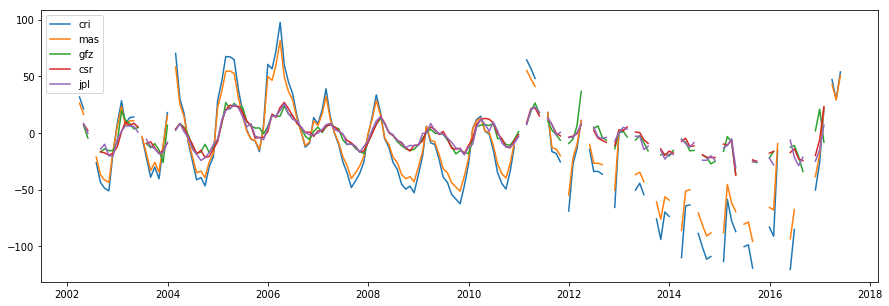

In [87]:
plt.figure(figsize=(15,5))

plt.plot(dt_idx, cri, label = "cri")
plt.plot(dt_idx, mas, label = "mas")
plt.plot(dt_idx, gfz, label = "gfz")
plt.plot(dt_idx, csr, label = 'csr')
plt.plot(dt_idx, jpl, label = 'jpl')
plt.legend()

In [88]:
# Make a dataframe

df = pd.DataFrame([cri,mas,gfz,csr,jpl]).T
df.columns = ["cri", "mas", "gfz", "csr", "jpl"]
df.index = dt_idx


In [111]:
# Polynomial interpolation to fill missing data

df2 = df.interpolate(method='polynomial', order=2)

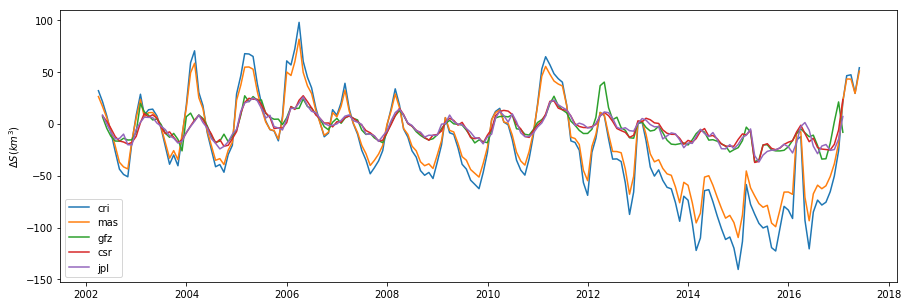

In [112]:
plt.figure(figsize=(15,5))

plt.plot(df2.cri, label = "cri")
plt.plot(df2.mas, label = 'mas')
plt.plot(df2.gfz, label = 'gfz')
plt.plot(df2.csr, label = 'csr')
plt.plot(df2.jpl, label = 'jpl')
plt.ylabel("$\Delta S (km^3)$")

plt.legend()

In [113]:
# JPL recommenda averaging CSR, GFZ, JPL https://grace.jpl.nasa.gov/data/choosing-a-solution/

df2['grace_mean'] = np.nanmean([df2.csr, df2.gfz, df2.jpl], axis = 0)

/Users/aakashahamed/anaconda3/envs/krige/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [114]:
print(np.mean(df2.grace_mean), np.min(df2.grace_mean), np.max(df2.grace_mean))

-4.296853301750158 -35.97373525112405 25.532665753111143


In [110]:
print(np.mean(df2.grace_mean), np.min(df2.grace_mean), np.max(df2.grace_mean))

-4.284676599514593 -37.248670028577976 25.532665753111143


In [106]:
print(np.mean(df2.grace_mean), np.min(df2.grace_mean), np.max(df2.grace_mean))

-3.584122158225516 -34.930572733265386 25.532665753111143


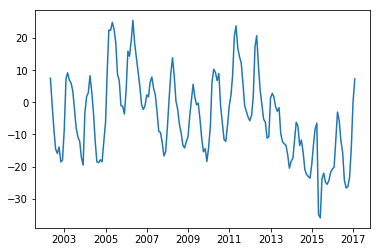

In [115]:
plt.plot(df2.grace_mean)

In [ ]:
df2.to_csv("../data/grace_cv.csv")